### Introduction

In this kernel I use XGBRegressor from XGBoost library to predict future prices of stocks using technical indicator as features. If you are looking for an explanation of indicators (e.g. moving averages, RSI, MACD) used below, please refer to [articles on Investopedia](https://www.investopedia.com/technical-analysis-4689657) or [this notebook of mine](https://www.kaggle.com/mtszkw/analysis-and-technical-indicators-for-trading-etfs) where I introduce and visualize various technical analysis concepts.

In [1]:
import os
import numpy as np
import pandas as pd
!pip install xgboost
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
# Time series decomposition
# pip install statsmodels==0.10.2 #!pip install stldecompose
# from stldecompose import decompose
# from .stl import decompose, forecast

# Chart drawing
# pip install plotly
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

### Read historical prices

I read historical data frame for a chosen stock (e.g. CERN) which I am going to analyze. New York Stock Exchange dataset provides day by day price history gathered over more than 10 years. I decided to crop the time frame and start it from a year 2010 to reduce amount of data to be processed.

Removing rows is then followed by reindexing the data frame to keep it clean.

In [3]:
df = pd.read_csv(r'D:\01_User\01_Nick_Yang\Desktop\Nick\NYCU_Graduate-school\courses_info\04-3Night_Big_data_analytics_&_Data_governance\Project\Datasets_Futures\training_data-1231-1.csv')
df.head()

FileNotFoundError: ignored

In [ ]:
df.rename(columns={'SP500_Index': 'Close'}, inplace = True)
df.head()

,Date,SP500_Index_std,Close,change_P,SP500_Index_shift,SP500_Index_std_shift,change_P_shift,SP500_Futures_Volume_std,SP500_Futures_ROC,SP500_Futures_close_std,...,NASDAQ_Futures_close_m,NASDAQ_Futures_close,DowJones_Futures_Volume_std,DowJones_Futures_ROC,DowJones_Futures_close_std,DowJones_Futures_close_m,DowJones_Futures_close,VIX_Index_close_std,VIX_Index_ROC,VIX_Index
0,4/8/2002,-0.762427,1125.290039,0.002280,1117.800049,-0.771727,-0.006656,-1.205275,0.22,-0.756233,...,70.150,1403.0,-1.530952,-0.22,-0.820097,2053.4,10267.0,-0.038479,2.509148,19.61
1,4/9/2002,-0.771727,1117.800049,-0.006656,1130.469971,-0.755996,0.011335,-1.230468,-0.66,-0.765432,...,67.800,1356.0,-1.530952,-0.44,-0.826911,2044.4,10222.0,-0.054368,-0.713921,19.47
2,4/10/2002,-0.755996,1130.469971,0.011335,1103.689941,-0.789246,-0.023689,-1.128769,1.05,-0.751020,...,67.825,1356.5,-1.507640,1.61,-0.801927,2077.4,10387.0,-0.199646,-6.574217,18.19
3,4/11/2002,-0.789246,1103.689941,-0.023689,1111.010010,-0.780157,0.006632,-1.107363,-2.50,-0.785670,...,66.575,1331.5,-1.505499,-2.09,-0.834784,2034.0,10170.0,0.039835,11.599780,20.30
4,4/12/2002,-0.780157,1111.010010,0.006632,1102.550049,-0.790661,-0.007615,-1.209971,0.72,-0.775858,...,67.650,1353.0,-1.517155,0.24,-0.831150,2038.8,10194.0,-0.060043,-4.334975,19.42


### OHLC Chart

I start with drawing an OHLC (open/high/low/close) chart to get a sense of historical prices. Below OHLC I draw Volume chart which shows number of stocks traded each day. In my previous notebook (linked above) I explain importance of OHLC and Volume charts in technical analysis.

### Decomposition

In [ ]:
df_SP500_P = df[['Date', 'Close']].copy()
df_SP500_P = df_SP500_P.set_index('Date')
df_SP500_P.head()

,Close
Date,
4/8/2002,1125.290039
4/9/2002,1117.800049
4/10/2002,1130.469971
4/11/2002,1103.689941
4/12/2002,1111.010010


### Technical indicators

#### Moving Averages

I'm calculating few moving averages to be used as features: $SMA_{5}$, $SMA_{10}$, $SMA_{15}$, $SMA_{30}$ and $EMA_{9}$.

In [ ]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

#### Relative Strength Index

I'll add RSI indicator to predict whether a stock is overbought/oversold.

In [ ]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

#### MACD

In [ ]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

### Shift label column

Because I want to predict the next day price, after calculating all features for day $D_{i}$, I shift Close price column by -1 rows. After doing that, for day $D_{i}$ we have features from the same timestamp e.g. $RSI_{i}$, but the price $C_{i+1}$ from upcoming day.

In [ ]:
df.head()

,Date,SP500_Index_std,Close,change_P,SP500_Index_shift,SP500_Index_std_shift,change_P_shift,SP500_Futures_Volume_std,SP500_Futures_ROC,SP500_Futures_close_std,...,VIX_Index_ROC,VIX_Index,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,4/8/2002,-0.762427,1125.290039,0.002280,1117.800049,-0.771727,-0.006656,-1.205275,0.22,-0.756233,...,2.509148,19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4/9/2002,-0.771727,1117.800049,-0.006656,1130.469971,-0.755996,0.011335,-1.230468,-0.66,-0.765432,...,-0.713921,19.47,1125.290039,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,4/10/2002,-0.755996,1130.469971,0.011335,1103.689941,-0.789246,-0.023689,-1.128769,1.05,-0.751020,...,-6.574217,18.19,1121.347939,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,4/11/2002,-0.789246,1103.689941,-0.023689,1111.010010,-0.780157,0.006632,-1.107363,-2.50,-0.785670,...,11.599780,20.30,1124.714002,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,4/12/2002,-0.780157,1111.010010,0.006632,1102.550049,-0.790661,-0.007615,-1.209971,0.72,-0.775858,...,-4.334975,19.42,1118.600580,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [ ]:
# # df['change_P'] = df['SP500_Index_Growth_shift']#SP500_Index_Growth_shift
# df['change_P'] = df['change_P'].shift(-1)
df['change_P'] = df['change_P_shift']
df['change_P']

0      -0.006656
1       0.011335
2      -0.023689
3       0.006632
4      -0.007615
          ...   
4827   -0.005406
4828   -0.001843
4829    0.008203
4830   -0.004632
4831    0.006005
Name: change_P, Length: 4832, dtype: float64

In [ ]:
df

,Date,SP500_Index_std,Close,change_P,SP500_Index_shift,SP500_Index_std_shift,change_P_shift,SP500_Futures_Volume_std,SP500_Futures_ROC,SP500_Futures_close_std,...,VIX_Index_ROC,VIX_Index,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,4/8/2002,-0.762427,1125.290039,-0.006656,1117.800049,-0.771727,-0.006656,-1.205275,0.22,-0.756233,...,2.509148,19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4/9/2002,-0.771727,1117.800049,0.011335,1130.469971,-0.755996,0.011335,-1.230468,-0.66,-0.765432,...,-0.713921,19.47,1125.290039,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2,4/10/2002,-0.755996,1130.469971,-0.023689,1103.689941,-0.789246,-0.023689,-1.128769,1.05,-0.751020,...,-6.574217,18.19,1121.347939,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
3,4/11/2002,-0.789246,1103.689941,0.006632,1111.010010,-0.780157,0.006632,-1.107363,-2.50,-0.785670,...,11.599780,20.30,1124.714002,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
4,4/12/2002,-0.780157,1111.010010,-0.007615,1102.550049,-0.790661,-0.007615,-1.209971,0.72,-0.775858,...,-4.334975,19.42,1118.600580,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4827,7/29/2021,3.327217,4419.149902,-0.005406,4395.259766,3.297556,-0.005406,-0.412209,0.41,3.271452,...,-3.331513,17.70,4353.133009,4400.733984,4363.110010,4363.307292,4319.191309,56.978490,36.873758,34.206186
4828,7/30/2021,3.297556,4395.259766,-0.001843,4387.160156,3.287499,-0.001843,0.032484,-0.50,3.244161,...,3.050847,18.24,4359.734698,4411.067969,4369.022021,4369.862630,4325.706299,51.459393,35.447501,34.454449
4829,8/2/2021,3.287499,4387.160156,0.008203,4423.149902,3.332184,0.008203,-0.189787,-0.22,3.232202,...,6.688596,19.46,4363.287205,4407.761914,4375.831982,4371.576628,4331.486296,52.514962,33.279979,34.219555
4830,8/3/2021,3.332184,4423.149902,-0.004632,4402.660156,3.306744,-0.004632,-0.064476,0.80,3.275438,...,-7.297020,18.04,4365.674500,4400.733984,4388.698975,4371.745312,4338.843294,56.298881,34.073496,34.190343


### Drop invalid samples

Because of calculating moving averages and shifting label column, few rows will have invalid values i.e. we haven't calculated $SMA_{10}$ for the first 10 days. Moreover, after shifting Close price column, last row price is equal to 0 which is not true. Removing these samples should help.

In [ ]:
dfs = df

In [ ]:
df

,Date,SP500_Index_std,Close,change_P,SP500_Index_shift,SP500_Index_std_shift,change_P_shift,SP500_Futures_Volume_std,SP500_Futures_ROC,SP500_Futures_close_std,...,VIX_Index_ROC,VIX_Index,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,4/8/2002,-0.762427,1125.290039,-0.006656,1117.800049,-0.771727,-0.006656,-1.205275,0.22,-0.756233,...,2.509148,19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4/9/2002,-0.771727,1117.800049,0.011335,1130.469971,-0.755996,0.011335,-1.230468,-0.66,-0.765432,...,-0.713921,19.47,1125.290039,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2,4/10/2002,-0.755996,1130.469971,-0.023689,1103.689941,-0.789246,-0.023689,-1.128769,1.05,-0.751020,...,-6.574217,18.19,1121.347939,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
3,4/11/2002,-0.789246,1103.689941,0.006632,1111.010010,-0.780157,0.006632,-1.107363,-2.50,-0.785670,...,11.599780,20.30,1124.714002,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
4,4/12/2002,-0.780157,1111.010010,-0.007615,1102.550049,-0.790661,-0.007615,-1.209971,0.72,-0.775858,...,-4.334975,19.42,1118.600580,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4827,7/29/2021,3.327217,4419.149902,-0.005406,4395.259766,3.297556,-0.005406,-0.412209,0.41,3.271452,...,-3.331513,17.70,4353.133009,4400.733984,4363.110010,4363.307292,4319.191309,56.978490,36.873758,34.206186
4828,7/30/2021,3.297556,4395.259766,-0.001843,4387.160156,3.287499,-0.001843,0.032484,-0.50,3.244161,...,3.050847,18.24,4359.734698,4411.067969,4369.022021,4369.862630,4325.706299,51.459393,35.447501,34.454449
4829,8/2/2021,3.287499,4387.160156,0.008203,4423.149902,3.332184,0.008203,-0.189787,-0.22,3.232202,...,6.688596,19.46,4363.287205,4407.761914,4375.831982,4371.576628,4331.486296,52.514962,33.279979,34.219555
4830,8/3/2021,3.332184,4423.149902,-0.004632,4402.660156,3.306744,-0.004632,-0.064476,0.80,3.275438,...,-7.297020,18.04,4365.674500,4400.733984,4388.698975,4371.745312,4338.843294,56.298881,34.073496,34.190343


In [ ]:
df.info()
print(df.isnull().sum())
print(df.count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4832 entries, 0 to 4831
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         4832 non-null   object 
 1   SP500_Index_std              4832 non-null   float64
 2   Close                        4832 non-null   float64
 3   change_P                     4832 non-null   float64
 4   SP500_Index_shift            4832 non-null   float64
 5   SP500_Index_std_shift        4832 non-null   float64
 6   change_P_shift               4832 non-null   float64
 7   SP500_Futures_Volume_std     4832 non-null   float64
 8   SP500_Futures_ROC            4832 non-null   float64
 9   SP500_Futures_close_std      4832 non-null   float64
 10  SP500_Futures_close_m        4832 non-null   float64
 11  SP500_Futures_close          4832 non-null   float64
 12  NASDAQ_Futures_Volume_std    4832 non-null   float64
 13  NASDAQ_Futures_ROC

In [ ]:
df.index = range(len(df))

# appraoch1
Here I split stock data frame into three subsets: training ($85\%$) and test ($15\%$) sets. I calculated split indices and create two separate frames (train_df, test_df). Both frames have been ploted in the chart below.
# appraoch2
Here I split stock data frame into three subsets: training ($70\%$), validation ($15\%$) and test ($15\%$) sets. I calculated split indices and create three separate frames (train_df, valid_df, test_df). All three frames have been ploted in the chart below.

In [ ]:
test_size  = 0.2
# valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
# valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:test_split_idx].copy()
# valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.change_P, name='Training'))
# fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.SP500_I, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.change_P,  name='Test'))
fig.show()

### Drop unnecessary columns

In [ ]:
drop_cols = ['Date', 'SP500_Index_std', 'SP500_Index_std_shift', 'change_P_shift']#'Volume', 'Open', 'Low', 'High', 'Close']#, 'OpenInt']

train_df = train_df.drop(drop_cols, 1)
# valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

In [ ]:
train_df.head()

,Close,change_P,SP500_Index_shift,SP500_Futures_Volume_std,SP500_Futures_ROC,SP500_Futures_close_std,SP500_Futures_close_m,SP500_Futures_close,NASDAQ_Futures_Volume_std,NASDAQ_Futures_ROC,...,VIX_Index_ROC,VIX_Index,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,1125.290039,-0.006656,1117.800049,-1.205275,0.22,-0.756233,22.560,1128.00,-0.450446,1.01,...,2.509148,19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1117.800049,0.011335,1130.469971,-1.230468,-0.66,-0.765432,22.410,1120.50,-0.423361,-3.35,...,-0.713921,19.47,1125.290039,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,1130.469971,-0.023689,1103.689941,-1.128769,1.05,-0.751020,22.645,1132.25,-0.223554,0.04,...,-6.574217,18.19,1121.347939,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,1103.689941,0.006632,1111.010010,-1.107363,-2.50,-0.785670,22.080,1104.00,-0.384965,-1.84,...,11.599780,20.30,1124.714002,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,1111.010010,-0.007615,1102.550049,-1.209971,0.72,-0.775858,22.240,1112.00,-0.644078,1.61,...,-4.334975,19.42,1118.600580,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [ ]:
test_df.head()

,Close,change_P,SP500_Index_shift,SP500_Futures_Volume_std,SP500_Futures_ROC,SP500_Futures_close_std,SP500_Futures_close_m,SP500_Futures_close,NASDAQ_Futures_Volume_std,NASDAQ_Futures_ROC,...,VIX_Index_ROC,VIX_Index,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
3866,2500.600098,0.000648,2502.219971,-0.281356,-0.17,0.927821,50.02,2501.0,0.325424,-0.56,...,-1.124744,9.67,2482.363406,2502.922021,2492.410034,2483.552034,2465.281038,65.181000,13.476058,10.309830
3867,2502.219971,-0.002222,2496.659912,-0.393778,-0.06,0.925981,49.99,2499.5,-0.107143,-0.16,...,-0.827301,9.59,2484.187075,2503.918017,2495.960034,2486.419368,2466.167041,63.940465,13.281272,10.904118
3868,2496.659912,0.000072,2496.840088,0.229299,-0.10,0.922914,49.94,2497.0,0.963913,-1.00,...,6.465068,10.21,2485.990365,2504.316016,2500.039038,2488.457373,2468.300708,74.584979,12.533771,11.230049
3869,2496.840088,0.004085,2507.040039,-0.248669,-0.06,0.921075,49.91,2495.5,0.325852,0.27,...,-0.391773,10.17,2487.057319,2502.873975,2500.894018,2489.798031,2470.145369,71.912613,11.819659,11.347971
3870,2507.040039,0.001205,2510.060059,0.273353,0.36,0.932114,50.09,2504.5,0.361375,0.82,...,-2.949853,9.87,2488.035596,2500.912012,2500.930029,2492.397363,2471.178703,75.831394,11.939145,11.466206


### Split into features and labels

In [ ]:
y_train = train_df['change_P'].copy()
X_train = train_df.drop(['change_P','Close', 'SP500_Index_shift'], 1)

# y_valid = valid_df['SP500_I'].copy()
# X_valid = valid_df.drop(['SP500_I'], 1)

y_test  = test_df['change_P'].copy()
X_test  = test_df.drop(['change_P','Close', 'SP500_Index_shift'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3866 entries, 0 to 3865
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SP500_Futures_Volume_std     3866 non-null   float64
 1   SP500_Futures_ROC            3866 non-null   float64
 2   SP500_Futures_close_std      3866 non-null   float64
 3   SP500_Futures_close_m        3866 non-null   float64
 4   SP500_Futures_close          3866 non-null   float64
 5   NASDAQ_Futures_Volume_std    3866 non-null   float64
 6   NASDAQ_Futures_ROC           3866 non-null   float64
 7   NASDAQ_Futures_close_std     3866 non-null   float64
 8   NASDAQ_Futures_close_m       3866 non-null   float64
 9   NASDAQ_Futures_close         3866 non-null   float64
 10  DowJones_Futures_Volume_std  3866 non-null   float64
 11  DowJones_Futures_ROC         3866 non-null   float64
 12  DowJones_Futures_close_std   3866 non-null   float64
 13  DowJones_Futures_c

In [ ]:
y_train.head()

0   -0.006656
1    0.011335
2   -0.023689
3    0.006632
4   -0.007615
Name: change_P, dtype: float64

In [ ]:
X_train.head()

,SP500_Futures_Volume_std,SP500_Futures_ROC,SP500_Futures_close_std,SP500_Futures_close_m,SP500_Futures_close,NASDAQ_Futures_Volume_std,NASDAQ_Futures_ROC,NASDAQ_Futures_close_std,NASDAQ_Futures_close_m,NASDAQ_Futures_close,...,VIX_Index_ROC,VIX_Index,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,-1.205275,0.22,-0.756233,22.560,1128.00,-0.450446,1.01,-0.744940,70.150,1403.0,...,2.509148,19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.230468,-0.66,-0.765432,22.410,1120.50,-0.423361,-3.35,-0.759906,67.800,1356.0,...,-0.713921,19.47,1125.290039,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,-1.128769,1.05,-0.751020,22.645,1132.25,-0.223554,0.04,-0.759747,67.825,1356.5,...,-6.574217,18.19,1121.347939,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,-1.107363,-2.50,-0.785670,22.080,1104.00,-0.384965,-1.84,-0.767707,66.575,1331.5,...,11.599780,20.30,1124.714002,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,-1.209971,0.72,-0.775858,22.240,1112.00,-0.644078,1.61,-0.760861,67.650,1353.0,...,-4.334975,19.42,1118.600580,NaN,NaN,NaN,NaN,0.0,NaN,NaN


### Model1
XGBoostRegressor

[0]	validation_0-rmse:0.35006	validation_1-rmse:0.34967
[1]	validation_0-rmse:0.24522	validation_1-rmse:0.24485
[2]	validation_0-rmse:0.17189	validation_1-rmse:0.17303
[3]	validation_0-rmse:0.12064	validation_1-rmse:0.12301
[4]	validation_0-rmse:0.08487	validation_1-rmse:0.08850
[5]	validation_0-rmse:0.06000	validation_1-rmse:0.06427
[6]	validation_0-rmse:0.04276	validation_1-rmse:0.04894
[7]	validation_0-rmse:0.03097	validation_1-rmse:0.03883
[8]	validation_0-rmse:0.02300	validation_1-rmse:0.03229
[9]	validation_0-rmse:0.01773	validation_1-rmse:0.02809
[10]	validation_0-rmse:0.01434	validation_1-rmse:0.02593
[11]	validation_0-rmse:0.01235	validation_1-rmse:0.02451
[12]	validation_0-rmse:0.01111	validation_1-rmse:0.02383
[13]	validation_0-rmse:0.01034	validation_1-rmse:0.02328
[14]	validation_0-rmse:0.00995	validation_1-rmse:0.02295
[15]	validation_0-rmse:0.00957	validation_1-rmse:0.02288
[16]	validation_0-rmse:0.00942	validation_1-rmse:0.02291
[17]	validation_0-rmse:0.00926	validation

[144]	validation_0-rmse:0.00246	validation_1-rmse:0.02371
[145]	validation_0-rmse:0.00244	validation_1-rmse:0.02372
[146]	validation_0-rmse:0.00241	validation_1-rmse:0.02372
[147]	validation_0-rmse:0.00240	validation_1-rmse:0.02372
[148]	validation_0-rmse:0.00236	validation_1-rmse:0.02372
[149]	validation_0-rmse:0.00233	validation_1-rmse:0.02373
[150]	validation_0-rmse:0.00231	validation_1-rmse:0.02374
[151]	validation_0-rmse:0.00230	validation_1-rmse:0.02373
[152]	validation_0-rmse:0.00229	validation_1-rmse:0.02373
[153]	validation_0-rmse:0.00227	validation_1-rmse:0.02374
[154]	validation_0-rmse:0.00224	validation_1-rmse:0.02374
[155]	validation_0-rmse:0.00219	validation_1-rmse:0.02374
[156]	validation_0-rmse:0.00219	validation_1-rmse:0.02374
[157]	validation_0-rmse:0.00217	validation_1-rmse:0.02374
[158]	validation_0-rmse:0.00215	validation_1-rmse:0.02374
[159]	validation_0-rmse:0.00212	validation_1-rmse:0.02374
[160]	validation_0-rmse:0.00210	validation_1-rmse:0.02374
[161]	validati

[286]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[287]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[288]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[289]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[290]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[291]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[292]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[293]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[294]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[295]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[296]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[297]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[298]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[299]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[300]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[301]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[302]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[303]	validati

[428]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[429]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[430]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[431]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[432]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[433]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[434]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[435]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[436]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[437]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[438]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[439]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[440]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[441]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[442]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[443]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[444]	validation_0-rmse:0.00129	validation_1-rmse:0.02391
[445]	validati

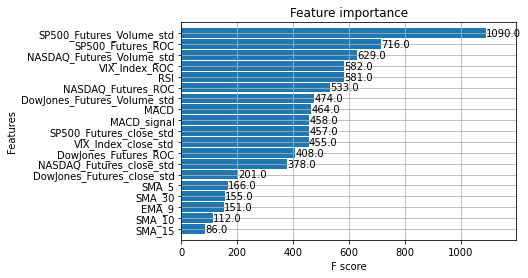

In [ ]:
#%% Create XGBoost Model
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=500,
       verbose=True) # Change verbose to True if you want to see it train
#Features Importance
_ = plot_importance(reg, height=0.9)

3866    0.000102
3867    0.000102
3868   -0.000227
3869    0.000102
3870    0.000102
          ...   
4827   -0.000985
4828   -0.000080
4829   -0.000080
4830   -0.000871
4831   -0.000080
Name: SP500_Prediction, Length: 966, dtype: float32

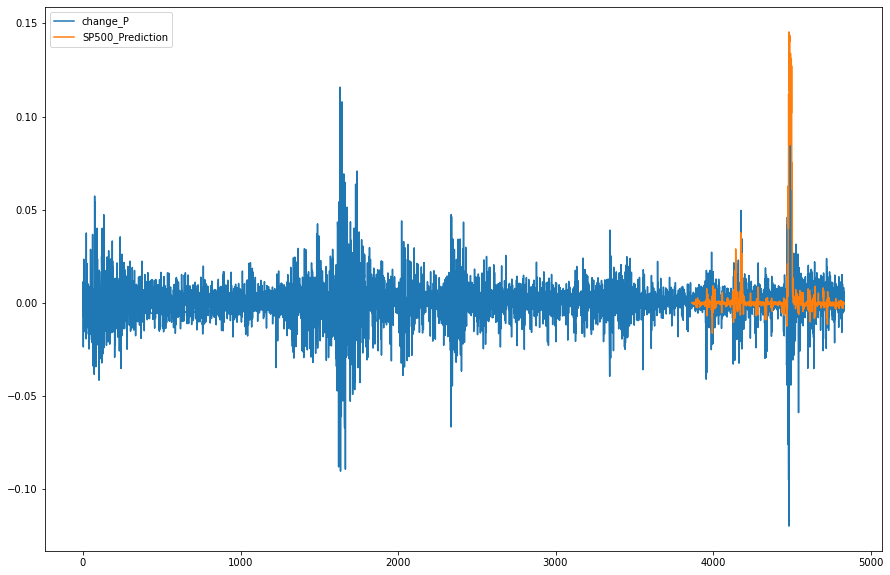

In [ ]:
#%%Forecast on Test Set
test_df['SP500_Prediction'] = reg.predict(X_test)
Data_all = pd.concat([test_df, train_df], sort=False)

_ = Data_all[['change_P','SP500_Prediction']].plot(figsize=(15, 10))
test_df['SP500_Prediction']

3866    2500.855863
3867    2502.475902
3868    2496.092192
3869    2497.095469
3870    2507.296463
           ...     
4827    4414.799030
4828    4394.907668
4829    4386.808707
4830    4419.295745
4831    4402.307465
Name: SP500_Prediction_I, Length: 966, dtype: float64

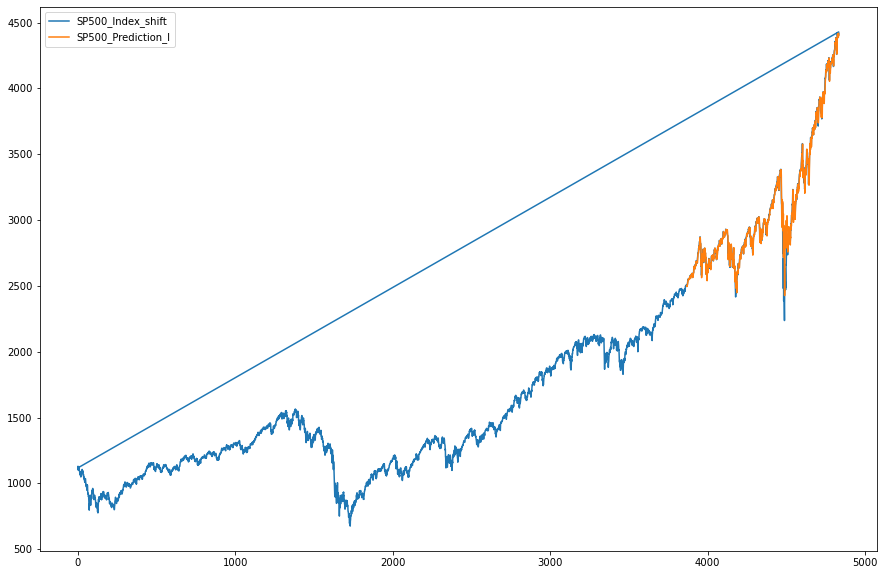

In [ ]:
test_df['SP500_Prediction'] = test_df['SP500_Prediction'] #Close change_P SP500_Index_shift
test_df['SP500_Prediction_I'] = test_df['Close']*(1+test_df['SP500_Prediction'])
# test_df['SP500_Prediction_I'] = test_df['SP500_Prediction_I'].shift(1)


Data_all_1 = pd.concat([test_df, train_df], sort=False)

_ = Data_all_1[['SP500_Index_shift','SP500_Prediction_I']].plot(figsize=(15, 10))
test_df['SP500_Prediction_I']

In [ ]:
#%%Error Metrics On Test Set
MSE = mean_squared_error(y_true=test_df['SP500_Index_shift'],
                         y_pred=test_df['SP500_Prediction_I'])
print("mean_squared_error : %d"%(MSE))

mean_squared_error : 3696


In [ ]:
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(y_true=test_df['SP500_Index_shift'],
                          y_pred=test_df['SP500_Prediction_I'])
print("mean_absolute_error : %d"%(MAE))

mean_absolute_error : 29


In [ ]:
test_df['change_P']

3866    0.000648
3867   -0.002222
3868    0.000072
3869    0.004085
3870    0.001205
          ...   
4827   -0.005406
4828   -0.001843
4829    0.008203
4830   -0.004632
4831    0.006005
Name: change_P, Length: 966, dtype: float64

In [ ]:
test_df['SP500_Prediction']

3866    0.000102
3867    0.000102
3868   -0.000227
3869    0.000102
3870    0.000102
          ...   
4827   -0.000985
4828   -0.000080
4829   -0.000080
4830   -0.000871
4831   -0.000080
Name: SP500_Prediction, Length: 966, dtype: float32

In [ ]:
# 兩個向量有相同的指向時，餘弦相似度的值為1；兩個向量夾角為90°時，餘弦相似度的值為0
from scipy import spatial
List1 = test_df['SP500_Index_shift']
List2 = test_df['SP500_Prediction_I']
result = 1 - spatial.distance.cosine(List1, List2)
print('Cosine_Similarity:',result)

Cosine_Similarity: 0.9998144948997959


# Model1-1

In [ ]:
#%% Create XGBoost Model
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=500,
       verbose=True) # Change verbose to True if you want to see it train


In [ ]:
#Features Importance
_ = plot_importance(reg, height=0.9)

#%%Forecast on Test Set
Data_test['SP500_Prediction'] = reg.predict(X_test)
Data_all = pd.concat([Data_test, Data_train], sort=False)

_ = Data_all[['SP500_Index_std','SP500_Prediction']].plot(figsize=(15, 10))

#%%Error Metrics On Test Set
mean_squared_error(y_true=Data_test['SP500_Index_std'],
                   y_pred=Data_test['SP500_Prediction'])
#%%
mean_absolute_error(y_true=Data_test['SP500_Index_std'],
                   y_pred=Data_test['SP500_Prediction'])
#%%

### Model2
Fine-tune XGBoostRegressor

In [ ]:
# %%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

In [ ]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

In [ ]:
plot_importance(model);

### Calculate and visualize predictions

In [ ]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

In [ ]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

In [ ]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()